In [1]:
import numpy as np

# 导入math库，主要使用其一些函数，比如取整函数、指数函数
import math

# 导入scipy.io库，主要用于读取matlab的mat文件
import scipy.io as scio

# 导入sns库，用于绘制热力图
import seaborn as sns

# 导入colors库，用于热力图的细节设置
import matplotlib.colors as mcolors

# 导入matplotlib.pyplot函数，用于绘制图片
import matplotlib.pyplot as plt

# 导入Image函数，用于旋转图片
from PIL import Image

# 导入train_test_split函数，用于分割训练集和测试集
from sklearn.model_selection import train_test_split

# 导入concatenate_sequences函数，用于将图片和分类转为特定的ndarray数组
from pyrcn.util import concatenate_sequences

# 导入pyrcn的增量回归器
from pyrcn.linear_model import IncrementalRegression

# 导入LabelBinarizer类，对y快速进行one-hot编码
from sklearn.preprocessing import LabelBinarizer

# 导入sklearn库的load_digits函数，用于加载手写数字数据集
from sklearn.datasets import load_digits as sklearn_load_digits

# 导入pyrcn.metrics的函数，用于计算分类后的混淆矩阵，准确度，精确度，召回率和f1得分
from pyrcn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

# 导入cast函数，用于保证类型为ndarray
from typing import cast

# pickle库用于保存随机矩阵，便于下次使用
import pickle

In [2]:
save_image_file = './image_save/'
save_data_file = './data_save/'

In [3]:
##  加载手写数字数据集  ##

# 二值化图像
X_ori, y_ori = sklearn_load_digits(n_class=10, return_X_y=True, as_frame=False)
for i in range(len(X_ori)):
    X_ori[i] = np.where(X_ori[i] <= 4, 0, 1)
X = np.empty(shape=(X_ori.shape[0],), dtype=object)
y = np.empty(shape=(X_ori.shape[0],), dtype=object)
for k, (X_single, y_single) in enumerate(zip(X_ori, y_ori)):
    X[k] = X_single.reshape(8, 8).T
    y[k] = np.atleast_1d(y_single)

# # 查看结果
# start_index = 10
# end_index = 11
# step = 1
# for test_id in range(start_index,end_index,step):
#     # 原始图片需要顺时针旋转90度再水平翻转才是正确结果
#     img_show = np.flip(np.rot90(X[test_id],k=-1),1)
#     print(img_show)
#     # 展示图片，不要太大
#     plt.figure(figsize=(1,1))
#     # 输出其对应的灰度图
#     plt.imshow(img_show,cmap='gray')
#     plt.show()
#     # 输出其对应的颜色图
#     plt.figure(figsize=(1,1))
#     plt.imshow(img_show)
#     plt.show()
    
# # 输出数据集图片数量和图片大小
# print("Number of digits: {0}".format(len(X)))
# print("Shape of digits {0}".format(X[test_id].shape))

In [4]:
# 将y中所有的单个值数组元素转为单个值，去掉元素内的数组包装
# 即对y进行如下转化：一维数组元素为一维数组->一维数组元素为值
stratify = np.asarray([np.unique(yt) for yt in y]).flatten()

# 将数据集乱序，分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify, random_state=42)

# 对训练集和测试集的数据进行深拷贝
X_tr = np.copy(X_train)
y_tr = np.copy(y_train)
X_te = np.copy(X_test)
y_te = np.copy(y_test)

# 遍历目标向量，每个元素从单个值扩展为1*8的数组元素
# 用于将值转化为一个序列，使得该问题转变为序列到序列的问题
for k, _ in enumerate(y_tr):
    y_tr[k] = np.repeat(y_tr[k], 8, 0)
for k, _ in enumerate(y_te):
    y_te[k] = np.repeat(y_te[k], 8, 0)

# # 输出一维ndarray值
# print(stratify)
# # 输出单个目标向量元素
# print(y_tr[0])
# # 输出训练集、测试集数据数量和图片大小
# print("Number of digits in training set: {0}".format(len(X_train)))
# print("Shape of digits in training set: {0}".format(X_train[0].shape))
# print("Number of digits in test set: {0}".format(len(X_test)))
# print("Shape of digits in test set: {0}".format(X_test[0].shape))

In [13]:
# 定义image_to_signal_draw类，用于将图片转为时域信号进行预测，通过random_sequence参数控制绘制时可重复使用random_sequence数组
class image_to_signal_draw:
    # 初始化函数
    def __init__(self,
                X_signal : np.array = None,
                Y_result : np.array = None,
                N_res : int = 50,
                K_in : int = -1,
                pulse_time : float = 1,
                time_frame : float = 3,
                interval_time : float = 2, 
                sparsity : float = -1,
                random_sequence: np.array = None):
        '''
        X_signal: 输入的图片，经过了二级化处理，可以根据像素确定是否有信号
        Y_result: 图片的分类结果，已进行了预处理后的图片，用于训练的拟合
        N_res: 隐藏层神经元数量，对应忆阻器的数量
        K_in: 稀疏性，对应的是每个忆阻器读取的每行图片元素数量
        pulse_time: 脉冲时间长度，对应的是单个信号的激活时间
        time_frame: 时间帧长度，对应的是单个信号的激活和衰减时间
        interval_time: 时间步间隔长度，对应的是每个
        sparsity: 稀疏性，对应的是每个忆阻器读取的每行图片元素数量比例
        random_sequence: 随机序列矩阵，从外面获得，使得不同类可共享
        '''
        # 根据mat文件设置激活信号的值计算和衰减值的计算
        self.up = scio.loadmat('../up.mat')["p"][0]
        self.down = scio.loadmat('../down.mat')["p2"][0]
        
        # 记录忆阻器数量
        self.N_res = N_res
        
        # 记录脉冲时间长度，时间帧长度和时间步的间隔长度
        self.pulse_time = pulse_time
        self.time_frame = time_frame
        self.interval_time = interval_time
        
        # 记录稀疏性和稀疏性比例
        self.K_in = K_in
        self.sparsity = sparsity
        
        # 对储备池状态信息进行拟合，使用回归器
        self.regressor = IncrementalRegression(alpha=1e-4)
        # 使用LabelBinarizer对分类进行one-hot编码
        self._encoder = LabelBinarizer()
        
        # 调用init_use函数，可以多次初始化输入图片和分类结果
        self.init_use(X_signal,Y_result)
        
        if random_sequence is not None:
            self.random_sequence = random_sequence
        else:
            self.random_sequence = np.zeros(shape = (self.N_res,self.num_step,self.num_frame), dtype=int)
            for i in range(self.N_res):
                for j in range(self.num_step):
                    self.random_sequence[i][j] = np.sort(np.random.permutation(self.N_features)[0:self.num_frame])
        
    #初始化使用函数，参数同上
    def init_use(self,
                X_signal : np.array = None,
                Y_result : np.array = None):
        
        # 记录输入图片和对应分类
        self.input = X_signal
        self.res = Y_result
        
        # 根据输入的图片大小计算时间步数量、时间帧数量和输入图片的特征数(即每行像素数量)
        self.num_step = self.input[0].shape[0]
        self.num_frame = self.input[0].shape[1]
        self.N_features = self.input[0].shape[1]

        if self.K_in > 0:
            if self.K_in <=  self.N_features:
                self.num_frame = self.K_in
        elif self.sparsity > 0:
            self.num_frame = math.ceil(self.sparsity*self.num_frame)
        

        
        # 记录忆阻器对应的储备池状态信息
        self.hidden_layer_state = np.ndarray(shape = (self.input.shape[0]),dtype = object)
        for i in range(self.hidden_layer_state.shape[0]):
            self.hidden_layer_state[i] = np.zeros(shape = (self.num_step,self.N_res),dtype = float)
        self.state_index = 0
        
        # 记录最新一次预测的储备池状态信息
        self.test_hidden_layer_state = None
        
        # 完成上述处理后，将输入图片和对应分类进行序列连接，得到相应的连续ndarray数组，用于进一步处理
        self.input,self.res,self.sequence_ranges = concatenate_sequences(self.input,
                                                                         self.res,
                                                                         sequence_to_value = False)
        
    # 定义脉冲激活函数
    def caculate_pulse_up(self,value):
        x = self.pulse_time
        up_value = self.up[0]* x**5 + \
                self.up[1]* x**4 + \
                self.up[2]* x**3 + \
                self.up[3]* x**2 + \
                self.up[4]* x + self.up[5]
        return value + up_value
    
    # 定义衰减函数,在遇到激活信号时进行时间结算,或者计算隐藏层状态信号
    def caculate_signal_down(self,value,have_down_time):
        x = have_down_time
        down_ratio = self.down[0] * math.exp(-self.down[1]*x) + self.down[2] + \
                     self.down[3] * math.exp(-self.down[4]*x) + self.down[5] + \
                     self.down[6] * math.exp(-self.down[7]*x) + self.down[8]
        return value * down_ratio
    
    # 定义时间帧计算函数
    def caculate_time_frame(self,value,have_down_time,signal):
        if signal == 0:
            return value, have_down_time + self.time_frame
        else:
            value = self.caculate_signal_down(value,have_down_time)
            value = self.caculate_pulse_up(value)
            return value, self.time_frame - self.pulse_time
         
    # 定义时间步计算函数
    def caculate_time_step(self,value,have_down_time,image_row,random_sequence):
        for i in range(random_sequence.shape[0]):
            value,have_down_time = self.caculate_time_frame(value,
                                                       have_down_time,
                                                       image_row[random_sequence[i]])
        return value, have_down_time
    
    # 定义忆阻器读取状态计算函数，对应储备池的神经元状态信息
    # 每次读取一张图片进行记录
    def caculate_hidden_layer_state(self, X: np.ndarray = None, 
                                    hidden_layer_state: np.ndarray = None,
                                    state_index: int = 0):
        
        # j循环是忆阻器群
        for j in range(self.N_res):
            # value是输入新的时间步时忆阻器的当前信号值
            value = 0.0
            # have_down_time是从上次激活开始的总衰减时间
            have_down_time = 0.0

            # k循环是时间步
            for k in range(self.num_step):
                # 计算忆阻器读取图片特定行转换的信号后的信号值变化和已衰减时间变化
                # 如没有激活信号，则信号不变，改变已衰减时间，从而在需要时计算新的激活前信号值
                value,have_down_time = self.caculate_time_step(value,
                                                          have_down_time,
                                                          X[k],
                                                          # self.input[i*self.num_step+k],
                                                          self.random_sequence[j][k])
                # 根据变化后的情况计算隐藏层状态
                hidden_layer_state[state_index][k][j] = self.caculate_signal_down(value,have_down_time)
                # 根据时间步间隔时间修改已衰减时间
                have_down_time += self.interval_time
        return hidden_layer_state
        
    # 定义部分训练函数，用于计算序列的部分图片，保证逆矩阵的推迟计算
    def partial_fit(self, 
                    X: np.ndarray = None, 
                    y: np.ndarray = None, 
                    postpone_inverse: bool = False):
        # 计算输入图片对应的储备池信息
        self.caculate_hidden_layer_state(X,self.hidden_layer_state,self.state_index)
        # 对图片进行拟合
        self.regressor.partial_fit(self.hidden_layer_state[self.state_index],y,postpone_inverse)
        # 状态索引+1
        self.state_index += 1

        
    # 定义训练函数,可以输入新的数据，也可以使用已有数据
    # 注意使用新的数据会导致原有的数据被重置
    def fit(self,
            X_train : np.ndarray = None, 
            Y_train : np.ndarray = None):
        # 修改输入的input和res
        if X_train is not None and Y_train is not None:
            self.init_use(X_train,y_train)
        
        # 对结果进行二进制编码，使用标签编码器,完成编码
        self._encoder = LabelBinarizer().fit(self.res)
        self.res = self._encoder.transform(self.res)
        
        # 拟合最后一张图片之前的图片，并推迟计算逆矩阵
        [self.partial_fit(X = self.input[idx[0]:idx[1],...],
                          y = self.res[idx[0]:idx[1],...],
                          postpone_inverse=True)
        for idx in self.sequence_ranges[:-1]]
        
        # 拟合最后一张不推迟逆矩阵的计算
        self.partial_fit(X = self.input[self.sequence_ranges[-1][0]:, ...],
                         y = self.res[self.sequence_ranges[-1][0]:, ...],
                         postpone_inverse=False)
    
    # 定义预测函数
    def predict(self, X_test: np.ndarray = None):
        # 初始化临时的储备池，用于记录测试集的结果
        hidden_layer_state = np.ndarray(shape = (X_test.shape[0]),dtype = object)
        for i in range(hidden_layer_state.shape[0]):
            hidden_layer_state[i] = np.zeros(shape = (self.num_step,self.N_res),dtype = float)
        
        # 记录图片索引
        state_index = 0
        
        # 记录预测结果
        y = np.empty(shape=X_test.shape, dtype=object)
        
        # 进行储备池计算
        for i in range(len(X_test)):
            self.caculate_hidden_layer_state(X_test[i], hidden_layer_state,state_index)
            # 计算后统计各时间步的可能性，
            y[i] = self.regressor.predict(hidden_layer_state[i])
            y[i] = self.softmax(cast(np.ndarray,np.sum(y[i], axis=0)))
            state_index += 1
            
        # 保存测试集的对应储备池
        self.test_hidden_layer_state = hidden_layer_state
        
        # 返回预测结果
        return y
    
    # 定义softmax函数，将值转为概率形式
    def softmax(self,x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / exp_x.sum(axis=-1, keepdims=True)

In [14]:
# 指标类，用于统计预测结果的各项指标和混淆矩阵的可视化
class metrics:
    def __init__(self,
                 y_test :np.ndarray,
                 y_predict :np.ndarray):
        '''
        y_test:真实的测试结果，一维的ndarray，每个元素依次是对应的结果
        y_predict:预测结果，一维或者二维的ndarray
        '''
        self.y_real = y_test
        self.y_all_predict = None
        self.y_predict = None
        
        # 如果测试结果与预测结果一一对应
        if len(y_predict[0]) == 1:
            self.y_predict = y_predict
        
        # 否则就是测试结果对各个分类结果均有预测
        else:
            self.y_all_predict = y_predict
            self.y_predict = np.copy(y_predict)
            for i in range(len(self.y_predict)):
                self.y_predict[i] = np.atleast_1d(np.argmax(self.y_predict[i]))
        
        # 计算准确率、精确率、召回率和混淆矩阵
        self._acc_score = accuracy_score(self.y_real,self.y_predict)
        self._pre_score = precision_score(self.y_real,self.y_predict,average='macro')
        self._rec_score = recall_score(self.y_real,self.y_predict,average='macro')
        self._confusion_matrix = confusion_matrix(self.y_real,self.y_predict)
        
    # 获得准确率
    @property
    def acc_score(self):
        return self._acc_score
    
    # 计算准确率
    @acc_score.setter
    def acc_score(self,acc_score):
        self._acc_score = acc_score
    
    # 获得精确率
    @property
    def pre_score(self):
        return self._pre_score
    
    # 计算精确率
    @pre_score.setter
    def pre_score(self,pre_score):
        self._pre_score = pre_score
        
    # 获得召回率
    @property
    def rec_score(self):
        return self._rec_score
    
    # 计算召回率
    @rec_score.setter
    def rec_score(self,rec_score):
        self._rec_score = rec_score
        
    # 获得混淆矩阵
    @property
    def confusion_matrix(self):
        return self._confusion_matrix
    
    # 计算混淆矩阵
    @confusion_matrix.setter
    def confusion_matrix(self,confusion_matrix):
        self._confusion_matrix = confusion_matrix
    
    # 混淆矩阵可视化
    def show_confusion_matrix(self):
        
        # 绘制设置的参数
        
        # 利用mcolors的LinearSegmentedColormap类的from_list函数
        # 通过线性插值设置颜色的起始渐变色，结束渐变色和插值数
        clist = ['skyblue','darkblue']
        newcmp = mcolors.LinearSegmentedColormap.from_list('chaos',clist,N=256)
        
        # 设置seaborn风格,字体设置为Times New Roman
        sns.set(font = 'Times New Roman')
        # 设置画布，大小为4*4
        fig, ax = plt.subplots(figsize=(4,4))

        # 设置seaborn绘图为热力图
        '''
        data对应矩阵，ax对应设置的图
        linecolor是分割线颜色，linewidths是分割线宽度
        cbar是设置图例，square是热力图的单元格是否为方格
        annot是是否要在方格展示数据
        cbar_kws是图例的设置参数
            orientation是图例方向
            pad是图例与热力图的距离
            fraction是图例的大小比例
        annot_kws是方格展示数据的设置参数
        '''
        sns.heatmap(data = self._confusion_matrix, 
                    ax = ax, 
                    vmin = 0, vmax = np.max(self._confusion_matrix),
                    cmap = newcmp,
                    linecolor="black", linewidths = 0.8, 
                    cbar = True, square = True,
                    annot = True,
                    cbar_kws={ 'orientation': 'vertical',
                               "pad": 0.05,
                               "fraction": 0.04},
                    annot_kws={'size': 9,
                               'weight': 'bold'})

        # 设置x轴和y轴的刻度内容和刻度位置
        ax.set_xticks(np.arange(0.5,10,1))
        ax.set_yticks(np.arange(0.5,10,1))
        ticklabels = [str(i) for i in range(0,10,1)]
        ax.set_xticklabels(ticklabels, color = 'black', rotation= 0, weight = 'bold')
        ax.set_yticklabels(ticklabels, color = 'black', weight = 'bold')

        # 设置刻度线和大小
        ax.tick_params(bottom=True, left=True, length=2.5, pad = 2, labelsize = 9)

        # 设置x轴和y轴的标签名和图名
        ax.set_xlabel("Predict digit", fontsize = 10, labelpad = 3, color = 'black', weight = 'bold')
        ax.set_ylabel("True digit", fontsize = 10 , labelpad = 3 , color = 'black', weight = 'bold')
        ax.set_title("Confusion matrix", fontsize = 11, color = 'black', weight = 'bold')

        # 获得图例对象
        cbar = ax.collections[0].colorbar
        # 图例标签内容
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')
        # 图例标签字体大小和取消刻度线
        cbar.ax.tick_params(labelsize=8, length = 0)
        
        # 保存和展示图像
        plt.savefig(save_image_file + 'Confusion_matrix.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
        plt.savefig(save_image_file + 'Confusion_matrix.eps', bbox_inches = 'tight', pad_inches = 0.05)
        plt.show()
    
    # 展示对单个图片的预测结果
    def show_one_image_predict(self,image_index):
        # 获得对应图片的各数字预测概率
        y_use = self.y_all_predict[image_index]
        
        # 设置字体为Times New Roman
        plt.rc('font',family='Times New Roman')
        
        # 绘制图像
        fig, ax = plt.subplots(figsize=(4,3))

        # 设置x轴和y轴的刻度内容和刻度位置
        ax.set_xticks(np.arange(1,11,1))
        ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9'], color = 'black', weight = 'bold')
        ax.set_yticklabels(ax.get_yticklabels(), color = 'black', weight = 'bold')
        ax.set_ylim(0,1)
        
        # 设置主刻度
        ax.tick_params(axis='x', direction='in', which='major', length=3, width=0.5)
        ax.tick_params(axis='y', direction='in', which='major', length=3, width=0.5)

        # 设置并激活次要刻度，只有y轴
        ax.minorticks_on()
        ax.tick_params(axis='y', direction='in', which='minor', length=1.5, width=0.5)
        ax.tick_params(axis='x', which='minor', length=0, bottom = False)
        
        # 设置x轴和y轴的标签名和图名
        ax.set_xlabel("Digit", fontsize = 9, labelpad = 3, color = 'black', weight = 'bold')
        ax.set_ylabel("Probability", fontsize = 9, labelpad = 3, color = 'black', weight = 'bold')
        ax.set_title("All probabilities of one handwritten digit image", fontsize = 10, color = 'black', weight = 'bold')
        
        # 绘制柱状图,设置x洲和y轴数据,柱宽度,柱的位置
        colors = ['deepskyblue' for _ in range(len(y_use))]
        colors[np.argmax(y_use)] = 'red'
        ax.bar(x = np.arange(1,11,1), height = y_use, 
               width=0.7, align="center",
               color=colors)
               # color=['dimgrey','red','darkorange','yellow','deepskyblue','limegreen','blueviolet','peru']
        
        ax.text(0.5, 0.95, 
                s= "\""+str(self.y_real[image_index][0])+"\"", ha='left', va='center', 
                fontsize=10, color='red', weight='bold')

        xticks = ax.get_xticks()
        for i in range(len(y_use)):
            xy = (xticks[i], y_use[i]+0.02)
            s = str(round(y_use[i],2))
            ax.annotate(
                text=s,  # 要添加的文本
                xy=xy,  # 将文本添加到哪个位置
                fontsize=8,  # 标签大小
                color="black",  # 标签颜色
                ha="center",  # 水平对齐
                va="baseline",  # 垂直对齐
                weight = 'bold' # 加粗
            )

        # 保存和展示图像
        plt.savefig(save_image_file + 'Dight_probabilities.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
        plt.savefig(save_image_file + 'Dight_probabilities.eps', bbox_inches = 'tight', pad_inches = 0.05)
        plt.show()

In [15]:
# 展示特定动态忆阻器的读取图片的随机位置函数
def show_choose_image_pos(random_sequence, index):
    '''
    random_sequence:动态忆阻器选择的每行的随机序列
    '''
    # 获得随机序列的对应时间步大小
    rd_size = random_sequence[index].shape[0]
    # 定义随机位置矩阵
    random_matrix = np.zeros(shape =  (rd_size, rd_size),
                             dtype = int)
    # 将序列转为矩阵
    for i in range(rd_size):
        random_matrix[i][random_sequence[index][i][0]] = 1
        random_matrix[i][random_sequence[index][i][1]] = 1
    
    
    # 绘制设置的参数
    
    # 数据值-颜色映射
    # 创建一个颜色标准化对象，指定了数据值的范围，将数据映射到颜色映射范围内的值
    norm = mcolors.Normalize(vmin=0, vmax=1)
    # 创建一个列表型颜色映射对象，用于映射0为颜色设置为(0.95, 0.95, 0.95)的值,映射1为blue
    cmap = mcolors.ListedColormap([(0.95, 0.95, 0.95), 'blue'])
    
    # 设置seaborn风格,字体设置为Times New Roman
    sns.set(font = 'Times New Roman')
    
    # 设置画布，大小为3*3
    fig, ax = plt.subplots(figsize=(3,3))
    
    # 设置seaborn绘图为热力图
    '''
    data对应随机矩阵，ax对应设置的图
    cmap对应颜色映射对象，norm对应数据-颜色映射标准化对象
    linecolor是分割线颜色，linewidths是分割线宽度
    cbar是设置图例，square是热力图的单元格是否为方格
    cbar_kws是图例的设置参数
            orientation是图例方向
            ticks是图例刻度位置
            pad是图例与热力图的距离
            fraction是图例的大小比例
            shrink是图例的缩放程度
    '''
    sns.heatmap(data = random_matrix, 
                ax = ax, vmin = 0, vmax = 1,
                cmap = cmap, norm = norm,
                linecolor="black", linewidths = 0.8, 
                cbar = True, square = True,
                cbar_kws={ 'orientation': 'vertical',
                           'ticks': [0.25,0.75],
                           "pad": 0.075,
                           "fraction": 0.04,
                           'shrink': 0.8})
    
    # 设置x轴和y轴的刻度和刻度标签样式
    
    # 设置刻度线位置
    ax.set_xticks(np.arange(0.5,8,1))
    ax.set_yticks(np.arange(0.5,8,1))
    # 设置刻度线标签内容
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'], color = 'black', weight = 'bold')
    ax.set_yticklabels(['1','2','3','4','5','6','7','8'], color = 'black', weight = 'bold')
    # 设置底部和左侧刻度线，刻度线标签字体大小,刻度标签到坐标轴距离,刻度线方向，刻度线长度
    ax.tick_params(bottom=True, left=True, labelsize=8, pad = 3, direction='out', length=4)
    
    # 设置坐标轴颜色、可视化和线宽
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(1.2)  
    ax.spines['left'].set_linewidth(1.2)  
    ax.spines['top'].set_linewidth(1.2)    
    ax.spines['right'].set_linewidth(1.2)  

    # 设置x轴和y轴的标签名和图名
    ax.set_xlabel("Selecting pixel", fontsize = 9, labelpad = 4, color = 'black', weight = 'bold')
    ax.set_ylabel("Time step", fontsize = 9, labelpad = 4 , color = 'black', weight = 'bold')
    ax.set_title("Selecting pixels at each time step", fontsize = 10, color = 'black', weight = 'bold')
    
    
    # 设置图例的刻度大小和内容映射
    
    # 获得图例对象
    cbar = ax.collections[0].colorbar
    # 图例标签内容
    cbar.set_ticklabels(['False', 'True'], weight = 'bold')
    # 图例标签字体大小和取消刻度线
    cbar.ax.tick_params(labelsize=8, length = 0)

    # 保存和展示图像
    plt.savefig(save_image_file + 'Choose_pixels.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
    plt.savefig(save_image_file + 'Choose_pixels.eps', bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()

In [16]:
# 展示特定动态忆阻器的读取特定图片后激活的随机位置函数
def show_choose_image_pos_with_image(random_sequence, index, input_image):
    '''
    random_sequence:动态忆阻器选择的每行的随机序列
    index:动态忆阻器索引
    input_image:输入的图片
    '''
    # 获得随机序列的对应时间步大小
    rd_size = random_sequence[index].shape[0]
    # 定义随机位置矩阵
    random_matrix = np.zeros(shape =  (rd_size, rd_size),
                             dtype = float)
    
    # 将序列转为矩阵
    for i in range(rd_size):
        for j in range(rd_size):
            if input_image[i][j] == 1:
                random_matrix[i][j] = 0.25
    for i in range(rd_size):
        if input_image[i][random_sequence[index][i][0]] == 1:
            random_matrix[i][random_sequence[index][i][0]] = 1
        else:
            random_matrix[i][random_sequence[index][i][0]] = 0.5
            
        if input_image[i][random_sequence[index][i][1]] == 1:
            random_matrix[i][random_sequence[index][i][1]] = 1
        else:
            random_matrix[i][random_sequence[index][i][1]] = 0.5

    
    # 绘制设置的参数
    
    # 数据值-颜色映射
    # 创建一个颜色标准化对象，指定了数据值的范围，将数据映射到颜色映射范围内的值
    norm = mcolors.Normalize(vmin=0, vmax=1)
    # 创建一个列表型颜色映射对象，将0映射为颜色设置为(0.95, 0.95, 0.95)的值,
    # 0.25映射为deepskyblue，0.5映射为blue，1映射为red
    cmap = mcolors.ListedColormap([(0.95, 0.95, 0.95),'deepskyblue','blue','red'])
    
    # 设置seaborn风格,字体设置为Times New Roman
    sns.set(font = 'Times New Roman')
    
    # 设置画布，大小为4*3
    fig, ax = plt.subplots(figsize=(4,3))
    
    # 设置seaborn绘图为热力图
    '''
    data对应随机矩阵，ax对应设置的图
    cmap对应颜色映射，norm对应数据-颜色映射
    linecolor是分割线颜色，linewidths是分割线宽度
    cbar是设置图例，square是热力图的单元格是否为方格
    cbar_kws是图例的设置参数
            orientation是图例方向
            ticks是图例刻度位置
            pad是图例与热力图的距离
            fraction是图例的大小比例
            shrink是图例的缩放程度
    '''
    sns.heatmap(data = random_matrix, 
                ax = ax, vmin = 0, vmax = 1,
                cmap = cmap, norm = norm,
                linecolor="black", linewidths = 0.8, 
                cbar = True, square = True,
                cbar_kws={ 'orientation': 'vertical',
                           'ticks': [0.125,0.375,0.625,0.875],
                           "pad": 0.075,
                           "fraction": 0.04,
                           'shrink': 0.8})
    
    # 设置x轴和y轴的刻度和刻度标签样式
    
    # 设置刻度线位置
    ax.set_xticks(np.arange(0.5,8,1))
    ax.set_yticks(np.arange(0.5,8,1))
    # 设置刻度线标签内容
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'], color = 'black', weight = 'bold')
    ax.set_yticklabels(['1','2','3','4','5','6','7','8'], color = 'black', weight = 'bold')
    # 设置底部和左侧刻度线，刻度线标签字体大小,刻度标签到坐标轴距离,刻度线方向，刻度线长度
    ax.tick_params(bottom=True, left=True, labelsize=8, pad = 3, direction='out', length=4)
    
    # 设置坐标轴颜色、可视化和线宽
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(1.2)  
    ax.spines['left'].set_linewidth(1.2)  
    ax.spines['top'].set_linewidth(1.2)    
    ax.spines['right'].set_linewidth(1.2)  
    
    # 设置x轴和y轴的标签名和图名
    ax.set_xlabel("Selecting pixel", fontsize = 9, labelpad = 4, color = 'black', weight = 'bold')
    ax.set_ylabel("Time step", fontsize = 9 , labelpad = 4 , color = 'black', weight = 'bold')
    ax.set_title("Pulse signals at each time step", fontsize = 10, color = 'black', weight = 'bold')

    
    # 设置图例的刻度大小和内容映射
    
    # 获得图例对象
    cbar = ax.collections[0].colorbar
    # 图例标签内容
    cbar.set_ticklabels(['No digital pixel','Unselected digital pixel','No pulse','Generate pulse'], weight = 'bold')
    # 图例标签字体大小和取消刻度线
    cbar.ax.tick_params(labelsize=8, length = 0)
    
    # 保存和展示图像
    plt.savefig(save_image_file + 'Pulse_signals_pixels.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
    plt.savefig(save_image_file + 'Pulse_signals_pixels.eps', bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()

In [17]:
# 展示特定动态忆阻器的状态函数
def show_dynamic_memristor_state(image_hidden_layer_state, index,image_digit):
    '''
    image_hidden_layer_state: 特定图片对应的储备池状态信息
    index: 要展示的动态忆阻器的索引
    image_digit: 图像对应的标签数字
    '''
    # 获得对应动态忆阻器的状态数量
    hls_size = image_hidden_layer_state.shape[0]
    
    # 记录对应索引位置的动态忆阻器的状态信息
    state_sequence = np.zeros(shape = (8), dtype = float)
    for i in range(8):
        state_sequence[i] = image_hidden_layer_state[i][index]
    
    # 设置字体为Times New Roman
    plt.rc('font',family='Times New Roman')
    
    # 绘制图像
    fig, ax = plt.subplots(figsize=(4,3))
    
    # 绘制柱状图,设置x洲和y轴数据,柱宽度,柱的位置
    ax.bar(x = np.arange(1,9,1), height = state_sequence, 
           width=0.7, align="center",
           color=['orangered'])
           # color=['dimgrey','red','darkorange','yellow','deepskyblue','limegreen','blueviolet','peru']

    # 设置主刻度
    ax.tick_params(axis='x', direction='in', which='major', length=4, width=0.8)
    ax.tick_params(axis='y', direction='in', which='major', length=4, width=0.8)

    # 设置并激活次要刻度
    ax.minorticks_on()
    ax.tick_params(axis='x', direction='in', which='minor', length=2, width=0.8)
    ax.tick_params(axis='y', direction='in', which='minor', length=2, width=0.8)
    
    # 设置x轴和y轴的刻度内容和刻度位置
    ax.set_xticks(np.arange(1,9,1))
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'], fontsize = 8, color = 'black', weight = 'bold')
    ax.set_ylim(0, state_sequence.max() * 1.1)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), fontsize = 8, color = 'black', weight = 'bold')
    
    # 设置x轴和y轴的标签名和图名
    ax.set_xlabel("Time step", fontsize = 9, labelpad = 4, color = 'black', weight = 'bold')
    ax.set_ylabel("State value", fontsize = 9, labelpad = 4 , color = 'black', weight = 'bold')
    ax.set_title("Dynamic memristor states", fontsize = 10, color = 'black', weight = 'bold')
    
    ax.text(0.5,state_sequence.max()* 1.09, 
            s= "\""+str(image_digit[0])+"\"", ha='left', va='center', 
            fontsize=11, color='red', weight='bold')
    
    xticks = ax.get_xticks()
    for i in range(len(state_sequence)):
        xy = (xticks[i], state_sequence[i] * 1.01 + 2)
        s = str(round(state_sequence[i],2))
        ax.annotate(
            text=s,  # 要添加的文本
            xy=xy,  # 将文本添加到哪个位置
            fontsize=7,  # 标签大小
            color="black",  # 标签颜色
            ha="center",  # 水平对齐
            va="baseline",  # 垂直对齐
            weight = 'bold' # 加粗
        )
    
    # 保存和展示图像
    plt.savefig(save_image_file + 'Dynamic_memristor_state.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
    plt.savefig(save_image_file + 'Dynamic_memristor_state.eps', bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()

In [18]:
# 展示特定动态忆阻器处理特定图片的信号变化图像
def show_all_time_step_image(itos:image_to_signal_draw,
                             input_image, 
                             dy_memristor_index):
    '''
    itos: 进行处理的image_to_signal_draw类的实例,此处限定类型
    input_image: 处理的特定图片
    dy_memristor_index:动态忆阻器索引
    '''
    
    # 计算时间步长度
    time_step_len = itos.num_frame * itos.time_frame
    all_time = itos.num_step * time_step_len + itos.interval_time * (itos.num_step - 1)
    # 单位时间内需要求的点数量
    onetime_numpoint = 5
    # 点的时间间隔
    time_point = 1.0/onetime_numpoint
    
    # 获得需要求的点数量
    total_time_point = all_time * onetime_numpoint
    # 记录最后绘图时的全部点信息
    res_sequence = np.zeros(shape = (total_time_point+1), dtype = float)
    res_state_sequence = np.zeros(shape = itos.num_step , dtype = float)
    
    # 获得初始值
    value = 0 
    have_down_time = 0
    
    # res_sequence索引和res_state_sequence索引
    res_index = 0
    res_state_index = 0
    # 遍历时间步每个时间步
    for step in range(itos.num_step):
        
        # 获得对应像素位置的值，并确定是否需要刺激信号
        pixels_pos = np.zeros(shape = len(itos.random_sequence[dy_memristor_index][step]),
                              dtype = int)
        for j in range(len(itos.random_sequence[dy_memristor_index][step])):
            pixels_pos[j] = itos.random_sequence[dy_memristor_index][step][j]
        for j in range(pixels_pos.shape[0]):
            if input_image[step][pixels_pos[j]] == 0:
                pixels_pos[j] = 0
            else:
                pixels_pos[j] = 1

        # 判断当前是激活还是衰减的标志
        up_down_flag = 0

        # 逐个计算
        for i in np.arange(0,time_step_len,time_point):

            # 否则如果i是时间帧开始时时间，且有激活信号
            if i % itos.time_frame == 0 and pixels_pos[int(i/itos.time_frame)]:
                # 先更新res_sequence的值
                res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
                # 再更新value和have_down_time
                value = res_sequence[res_index]
                have_down_time = 0
                # 最后标志设置为激活
                up_down_flag = 1

            # 否则如果i是时间帧开始时时间，且没有激活信号
            elif i % itos.time_frame == 0:
                # 先更新res_sequence的值
                res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
                # 不需要更新value,只更新have_down_time
                have_down_time += time_point
                # 最后标志设置为衰减
                up_down_flag = 0

            # 否则如果i是时间帧范围内的脉冲时间
            elif i % itos.time_frame <= itos.pulse_time:
                # 如果处理激活状态
                if up_down_flag:
                    # 以激活的方式计算res_sequence的值
                    x = i % itos.time_frame
                    up_value = itos.up[0]* x**5 + \
                               itos.up[1]* x**4 + \
                               itos.up[2]* x**3 + \
                               itos.up[3]* x**2 + \
                               itos.up[4]* x + itos.up[5]
                    # 利用激活值和value计算
                    res_sequence[res_index] = up_value + value
                    # 如果激活时间结束,修改value和have_down_time的值,否则不需要处理
                    if i % itos.time_frame == itos.pulse_time:
                        value = res_sequence[res_index]
                        have_down_time = time_point
                # 如果处于下降状态
                else:
                    # 先更新res_sequence的值
                    res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
                    # 不需要更新value,只更新have_down_time
                    have_down_time += time_point

            # 否则i是时间帧范围内的衰减时间
            else:
                # 先更新res_sequence的值
                res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
                # 不需要更新value,只更新have_down_time
                have_down_time += time_point

            # 更新res的索引，计算下一个值
            res_index+=1
        
        # 记录状态对应的值
        res_state_sequence[res_state_index] = itos.caculate_signal_down(value,have_down_time)
        res_state_index += 1
        
        # 除了最后一个时间步外需要考虑时间步间隔时间
        if step != itos.num_step -1:
            for i in np.arange(0,itos.interval_time,time_point):
                res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
                have_down_time += time_point
                res_index+=1
        else:    
            res_sequence[-1] = itos.caculate_signal_down(value,have_down_time)

    # 设置字体为Times New Roman
    plt.rc('font',family='Times New Roman')
    
    # 设置曲线和散点颜色
    color_use1 = [33/255.0,158/255.0,188/255.0]
    color_use2 = [185/255.0,50/255.0,50/255.0]
    
    # 图像绘制，创建画布
    fig, ax = plt.subplots(figsize=(4,4))
    
    # 绘制变化曲线
    ax.plot(np.arange(0,all_time+time_point,time_point), res_sequence, color=color_use1, label='Time step', linewidth = 2.5)
    # 标记散点
    ax.scatter(np.arange(time_step_len,all_time+time_step_len,time_step_len+itos.interval_time), 
                res_state_sequence,
                zorder = 2,
                s = 10,
                color = color_use2)
    # 已取消，标记值
    # for i in zip(np.arange(time_step_len,all_time+time_step_len,time_step_len+itos.interval_time), res_state_sequence):
    #     plt.annotate('(' + str(i[0]) + ',' + str(round(i[1],1)) + ')', 
    #                  xy = i,
    #                  xytext = (i[0], i[1]+5),
    #                  fontsize = 7,
    #                  ha ='center', va ='bottom')
    
    # 设置主刻度
    ax.tick_params(axis='x', direction='in', which='major', length=4, width=0.8)
    ax.tick_params(axis='y', direction='in', which='major', length=4, width=0.8)

    # 设置并激活次要刻度
    ax.minorticks_on()
    ax.tick_params(axis='x', direction='in', which='minor', length=2, width=0.8)
    ax.tick_params(axis='y', direction='in', which='minor', length=2, width=0.8)
    
    # 设置x轴标签，y轴标签、标题并保存内容
    ax.set_xlabel('Time(s)', fontsize = 10, color = 'black', weight = 'bold')
    ax.set_ylabel('Dynamic memristor response',fontsize = 10, color = 'black', weight = 'bold')
    ax.set_title('All time steps', fontsize = 11, color = 'black', weight = 'bold')
    
    # 加粗刻度线标签
    ax.set_xticklabels(ax.get_xticklabels(),color = 'black', weight = 'bold')
    ax.set_yticklabels(ax.get_yticklabels(),color = 'black', weight = 'bold')
    
    # 加粗边框
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(1.2)  
    ax.spines['left'].set_linewidth(1.2)  
    ax.spines['top'].set_linewidth(1.2)    
    ax.spines['right'].set_linewidth(1.2)  
    
    plt.savefig(save_image_file + 'All_time_steps_response.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
    plt.savefig(save_image_file + 'All_time_steps_response.eps', bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()

In [19]:
# 以热力图的形式展示输入某个数字时的整个储备池
def show_Reservoir_Computing(itos:image_to_signal_draw,
                             image_index,
                             test_flag = True):
    # 记录储备池的动态忆阻器数量
    rc_size = itos.N_res
    
    # 根据输入数字是训练集还是测试集决定读取的储备池
    data = None
    if test_flag:
        data = itos.test_hidden_layer_state[image_index]
    else:
        data = itos.hidden_layer_state[image_index]
        
    # 绘制设置的参数
    # 设置seaborn风格,字体设置为Times New Roman
    sns.set(font = 'Times New Roman')
    # 设置画布，大小为5*5
    fig, ax = plt.subplots(figsize=(15,3.75))
    
    # 设置seaborn绘图为热力图
    '''
    data对应随机矩阵，ax对应设置的图
    cmap对应颜色映射，norm对应数据-颜色映射
    linecolor是分割线颜色，linewidths是分割线宽度
    cbar是设置图例，square是热力图的单元格是否为方格
    cbar_kws是图例的设置参数
            orientation是图例方向
            ticks是图例刻度位置
            pad是图例与热力图的距离
            fraction是图例的大小比例
    '''
    sns.heatmap(data = data, 
                ax = ax, 
                vmin = 0, vmax = np.max(data),
                cmap = 'OrRd',
                # linecolor="black", linewidths = 0.005, 
                cbar = True, square = False,
                cbar_kws={ 'orientation': 'vertical',
                           "pad": 0.03,
                           "fraction": 0.04}
                           )
    # 获得图例对象
    cbar = ax.collections[0].colorbar
    # 图例标签字体大小,取消图例刻度线
    cbar.ax.tick_params(labelsize=9, length = 0)
    # 加粗图例标签
    cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')
    
    # 设置x轴和y轴的刻度内容和刻度位置
    xticks = np.arange(-0.5,rc_size,10)
    xticks[0] = 0.5
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(0.5,8,1))
    xticklabels = [str(i) for i in range(0,rc_size+1,10)]
    xticklabels[0] = '1'
    ax.set_xticklabels(xticklabels, color = 'black', rotation= 0, weight = 'bold', fontsize = 10)
    ax.set_yticklabels(['1','2','3','4','5','6','7','8'], color = 'black', weight = 'bold', fontsize = 10)

    # 设置刻度线和大小
    ax.tick_params(bottom = True, left = True, length = 2)
    ax.tick_params(labelsize=9)

    
    # 设置x轴和y轴的标签名和图名
    ax.set_xlabel("Encoding number of dynamic memristor", fontsize = 14, labelpad = 3, color = 'black', weight = 'bold')
    ax.set_ylabel("Time step", fontsize = 14 , labelpad = 3 , color = 'black', weight = 'bold')
    ax.set_title("Reservoir state values", fontsize = 16, color = 'black', weight = 'bold')
    
    
    # 保存和展示图像
    plt.savefig(save_image_file + 'RC_state_values.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
    plt.savefig(save_image_file + 'RC_state_values.eps', bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()

In [20]:
## 模型训练和预测 ##
random_sequence_cache = False
random_sequence_save = False
if random_sequence_cache:
    with open(save_data_file+'random_sequence'+'.pkl', 'rb') as f:
        use_random_sequence = pickle.load(f)
else:
    use_random_sequence = None
# 创建实例，进行训练和预测
example = image_to_signal_draw(X_signal = X_tr, Y_result= y_tr, N_res = 400, K_in = 2,
                          pulse_time = 1, time_frame = 4, interval_time = 2,
                          random_sequence = use_random_sequence)
example.fit()
y_te_predict = example.predict(X_test = X_te)

if random_sequence_save:
      with open(save_data_file+'random_sequence'+'.pkl', 'rb') as f:
        pickle.dump(example.random_sequence,f)

In [21]:
##  展示测试集的测试结果  ##
# 创建指标类实例
metric = metrics(y_test,y_te_predict)

# 指定进行展示图片索引、动态忆阻器索引和时间步索引
image_index = 0
dynamic_memristor_index = 15
time_step_index = 3

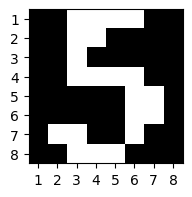

第1张图片:

原始图像:


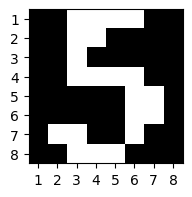

正确标签结果:[5]


读取图像:


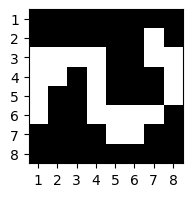

In [23]:
# 展示原始图像、变换后的图像

img_show = np.flip(np.rot90(X_test[image_index],k=-1),1)
plt.figure(figsize=(2,2))
plt.imshow(img_show,cmap='gray')
plt.xticks(np.arange(0,8,1),['1','2','3','4','5','6','7','8'])
plt.yticks(np.arange(0,8,1),['1','2','3','4','5','6','7','8'])
plt.savefig(save_image_file + "Original_image.tiff", bbox_inches = 'tight', pad_inches = 0.05,dpi=600)
plt.savefig(save_image_file + "Original_image.eps", bbox_inches = 'tight', pad_inches = 0.05)
plt.show()
plt.rcdefaults()

print("第"+str(image_index+1)+"张图片:\n")
print("原始图像:")
img_show = np.flip(np.rot90(X_te[image_index],k=-1),1)
plt.figure(figsize=(2,2))
plt.imshow(img_show,cmap='gray')
plt.xticks(np.arange(0,8,1),['1','2','3','4','5','6','7','8'])
plt.yticks(np.arange(0,8,1),['1','2','3','4','5','6','7','8'])
plt.savefig(save_image_file + "Binary_image.tiff", bbox_inches = 'tight', pad_inches = 0.05, dpi=600)
plt.savefig(save_image_file + "Binary_image.eps", bbox_inches = 'tight', pad_inches = 0.05)
plt.show()
print("正确标签结果:",y_test[image_index],sep="")
plt.rcdefaults()
print('\n')

print("读取图像:")
img_show = X_te[image_index]
plt.figure(figsize=(2,2))
plt.imshow(img_show,cmap='gray')
plt.xticks(np.arange(0,8,1),['1','2','3','4','5','6','7','8'])
plt.yticks(np.arange(0,8,1),['1','2','3','4','5','6','7','8'])
plt.savefig(save_image_file + "Horizontal_rotation_image.tiff", bbox_inches = 'tight', pad_inches = 0.05, dpi=600)
plt.savefig(save_image_file + "Horizontal_rotation_image.eps", bbox_inches = 'tight', pad_inches = 0.05)
plt.show()
plt.rcdefaults()
print('\n')

第16个动态忆阻器的每个时间步选择读取像素位置的图像:


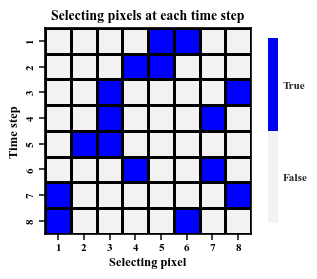



第16个动态忆阻器的每个时间步产生脉冲信号的图像:


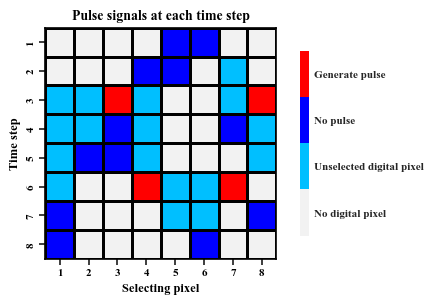



第16个动态忆阻器的全时间步状态变化图像:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\3995861642.py:159: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),color = 'black', weight = 'bold')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\3995861642.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),color = 'black', weight = 'bold')


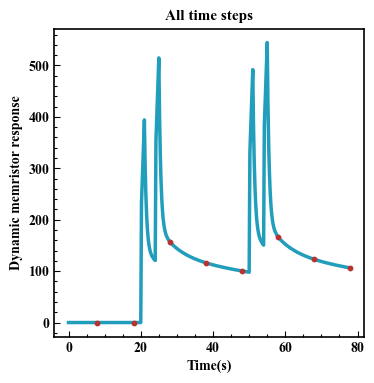



第16个动态忆阻器读取第1张图片的状态:


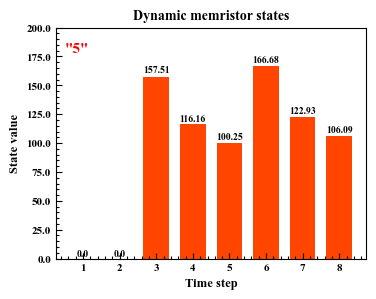


------------------------------------------------------------------------


读取图像的储备池状态:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\2492373978.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')


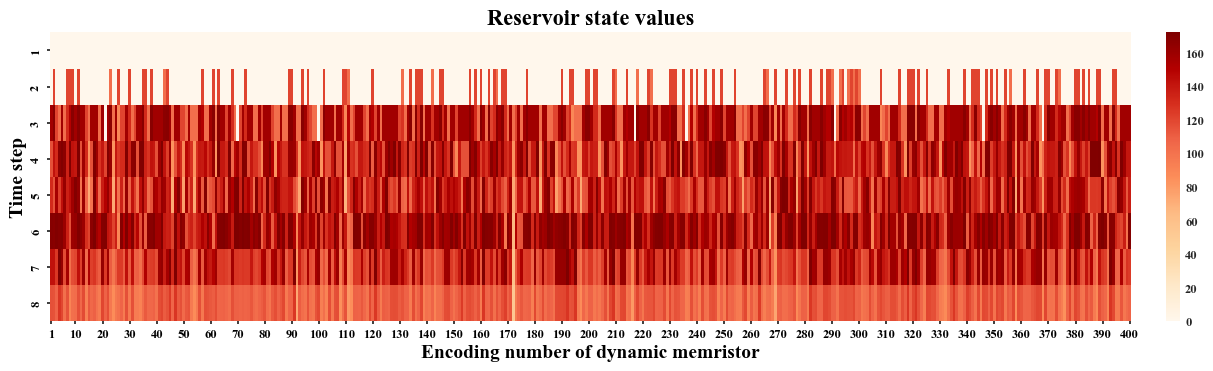



读取图像的各数字预测概率:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\1475318038.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), color = 'black', weight = 'bold')


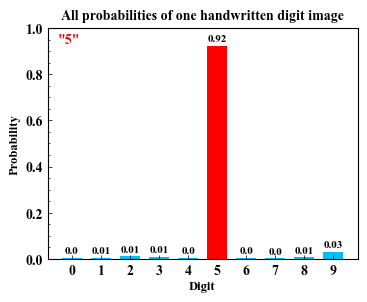

预测标签结果:[5]


------------------------------------------------------------------------


测试集的总体情况:
acc_score:0.9194444444444444
pre_score:0.9195769518546287
rec_score:0.9192685542685541


测试集的混淆矩阵:


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\1475318038.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), weight='bold')


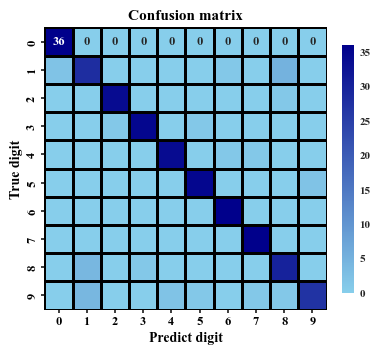



测试集的第1张手写数字图片:


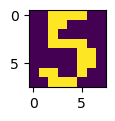

Label:5
Prediction:5

测试集的第2张手写数字图片:


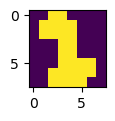

Label:2
Prediction:2

测试集的第3张手写数字图片:


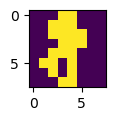

Label:8
Prediction:8

测试集的第4张手写数字图片:


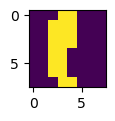

Label:1
Prediction:8

测试集的第5张手写数字图片:


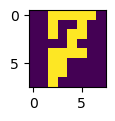

Label:7
Prediction:7



In [25]:
# 展示所有需要绘制的图像

for i in range(1):
    print("第"+str(dynamic_memristor_index+1+i)+"个动态忆阻器的每个时间步选择读取像素位置的图像:")
    show_choose_image_pos(example.random_sequence,dynamic_memristor_index+i)
    plt.rcdefaults()
    print('\n')
    
    print("第"+str(dynamic_memristor_index+1+i)+"个动态忆阻器的每个时间步产生脉冲信号的图像:")
    show_choose_image_pos_with_image(example.random_sequence,dynamic_memristor_index+i,X_te[image_index])
    plt.rcdefaults()
    print('\n')
    
    print("第"+str(dynamic_memristor_index+1+i)+"个动态忆阻器的全时间步状态变化图像:")
    show_all_time_step_image(example,X_te[image_index],dynamic_memristor_index+i)
    plt.rcdefaults()
    print('\n')
    
    # print("第"+str(dynamic_memristor_index+1+i)+"个动态忆阻器的第"+str(time_step_index+1)+"个时间步的状态变化图像:")
    # show_time_step_image(example,X_te[image_index],dynamic_memristor_index+i,time_step_index)
    # plt.rcdefaults()
    # print('\n')
    
    print("第"+str(dynamic_memristor_index+1+i)+"个动态忆阻器读取第"+str(image_index+1)+"张图片的状态:")
    show_dynamic_memristor_state(example.test_hidden_layer_state[image_index],dynamic_memristor_index+i,y_test[image_index])
    plt.rcdefaults()
    print()
    
    print("------------------------------------------------------------------------")
    print('\n')

# 展示整个储备池
print("读取图像的储备池状态:")
show_Reservoir_Computing(example,image_index,test_flag=True)
plt.rcdefaults()
print('\n')

# 可视化特定手写图片对各数字的预测概率
print("读取图像的各数字预测概率:")
metric.show_one_image_predict(image_index)
print("预测标签结果:[",np.argmax(y_te_predict[image_index]),']',sep="")
plt.rcdefaults()
print('\n')

print("------------------------------------------------------------------------")
print('\n')


# 测试集的整体结果:

print("测试集的总体情况:")
# 输出准确率、精确率和召回率
print("acc_score:"+str(metric.acc_score))
print("pre_score:"+str(metric.pre_score))
print("rec_score:"+str(metric.rec_score))
print('\n')

# 可视化混淆矩阵
print("测试集的混淆矩阵:")
metric.show_confusion_matrix()
plt.rcdefaults()
print('\n')

# 展示部分图片的预测结果
for i in range(image_index,image_index+5,1):
    print("测试集的第",i+1,"张手写数字图片:",sep="")
    # 原始图片需要顺时针旋转90度再水平翻转才是正确结果
    img_show=np.flip(np.rot90(X_test[i],k=-1),1)
    #展示图片，不要太大
    plt.figure(figsize=(1,1))
    plt.imshow(img_show)
    # plt.imshow(img_show,cmap='gray')
    plt.show()
    print("Label:",y_test[i][0],sep="")
    print("Prediction:",np.argmax(y_te_predict[i]),'',sep="")
    plt.rcdefaults()
    print()

# np.set_printoptions(threshold=np.inf)
# print(example.hidden_layer_state[image_index])
# np.set_printoptions()

In [27]:
## 计算随动态忆阻器使用数量的准确率列表 ##

acc_list = []
start = 10
end = 401
step_num = 10
# 根据变化的忆阻器数量进行训练
for i in range(start,end,step_num):
    example_temp = image_to_signal_draw(X_signal = X_tr, Y_result= y_tr, N_res = i, K_in = 2,
                          pulse_time = 1, time_frame = 4, interval_time = 2)
    example_temp.fit()
    y_pre_temp = example_temp.predict(X_test = X_te)
    metric_temp = metrics(y_test,y_pre_temp)
    acc_list.append(metric_temp.acc_score)
print(acc_list)

[0.5361111111111111, 0.6861111111111111, 0.7138888888888889, 0.775, 0.8194444444444444, 0.8277777777777777, 0.8388888888888889, 0.8638888888888889, 0.8472222222222222, 0.8527777777777777, 0.8638888888888889, 0.8611111111111112, 0.8583333333333333, 0.8833333333333333, 0.8777777777777778, 0.8944444444444445, 0.9027777777777778, 0.8805555555555555, 0.8916666666666667, 0.8888888888888888, 0.8861111111111111, 0.8861111111111111, 0.8972222222222223, 0.9055555555555556, 0.9, 0.9111111111111111, 0.9, 0.8888888888888888, 0.8916666666666667, 0.8972222222222223, 0.9, 0.9166666666666666, 0.9055555555555556, 0.9055555555555556, 0.9138888888888889, 0.8444444444444444, 0.9083333333333333, 0.9194444444444444, 0.9111111111111111, 0.9305555555555556]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\3082534079.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),color = 'black', weight = 'bold')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11060\3082534079.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),color = 'black', weight = 'bold')


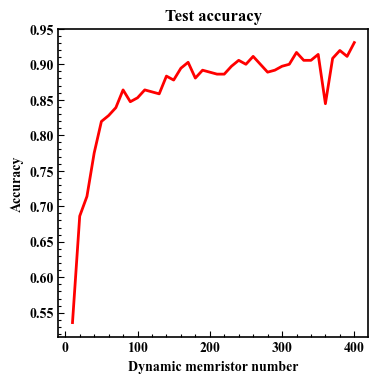

In [28]:
## 根据动态忆阻器数量-准确率信息绘制变化曲线 ##

# 设置字体为Times New Roman
plt.rc('font',family='Times New Roman')
# 图像绘制，创建画布
fig, ax = plt.subplots(figsize=(4,4))
# 绘制曲线
ax.plot(np.arange(start,end,step_num), acc_list, color='red', label='dym_num-acc', linewidth = 2)

# 加粗刻度线标签
ax.set_xticklabels(ax.get_xticklabels(),color = 'black', weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),color = 'black', weight = 'bold')

# 加粗边框
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_linewidth(1.2)  
ax.spines['left'].set_linewidth(1.2)  
ax.spines['top'].set_linewidth(1.2)    
ax.spines['right'].set_linewidth(1.2)  

# 设置主刻度
ax.tick_params(axis='x', direction='in', which='major', length=4, width=0.8)
ax.tick_params(axis='y', direction='in', which='major', length=4, width=0.8)

# 设置并激活次要刻度
ax.minorticks_on()
ax.tick_params(axis='x', direction='in', which='minor', length=2, width=0.8)
ax.tick_params(axis='y', direction='in', which='minor', length=2, width=0.8)

# 设置x轴标签，y轴标签、标题并保存内容
plt.xlabel('Dynamic memristor number', fontsize = 10, color = 'black', weight = 'bold')
plt.ylabel('Accuracy', fontsize = 10, color = 'black', weight = 'bold')
plt.title('Test accuracy', fontsize = 12, color = 'black', weight = 'bold')

plt.savefig(save_image_file + 'Test_accuracy.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
plt.savefig(save_image_file + 'Test_accuracy.eps', bbox_inches = 'tight', pad_inches = 0.05)

plt.show()
plt.rcdefaults()

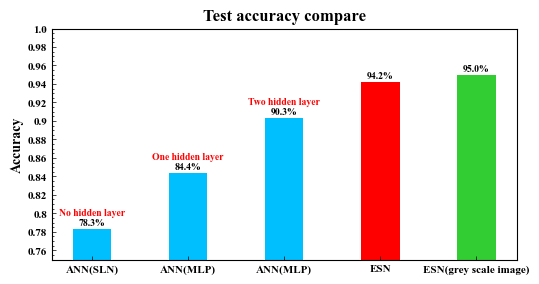

In [29]:
## 绘制各类神经网络测试准确率的对比图 ##

Accuracy = [0.783, 0.844, 0.903, 0.942, 0.95]
ACC_NUM = len(Accuracy)

# # 设置字体为Times New Roman
plt.rc('font',family='Times New Roman')

# 绘制图像
fig, ax = plt.subplots(figsize=(6,3))

# 绘制柱状图,设置x洲和y轴数据,柱宽度,柱的位置
ax.bar(x = np.arange(1,ACC_NUM+1,1), height = Accuracy, 
       width=0.4, align="center",
       color=['deepskyblue', 'deepskyblue', 'deepskyblue', 'red', 'limegreen'])
       # color=['dimgrey','red','darkorange','yellow','deepskyblue','limegreen','blueviolet','peru']

# 设置x轴和y轴的刻度内容和刻度位置
ax.set_xticks(np.arange(1,ACC_NUM+1,1))
ax.set_xticklabels(['ANN(SLN)','ANN(MLP)','ANN(MLP)','ESN','ESN(grey scale image)'], color = 'black', fontsize = 8, weight = 'bold')
ax.set_ylim(0.75,1.0)
ax.set_yticks(np.arange(0.76,1.02,0.02))
y_ticklabels = [str(round(i,2)) for i in np.arange(0.76,1.02,0.02)]
ax.set_yticklabels(y_ticklabels, fontsize = 8, weight = 'bold')

# 设置y轴的标签名和图名
ax.set_ylabel("Accuracy", fontsize = 10, labelpad = 3 , color = 'black', weight = 'bold')
ax.set_title("Test accuracy compare", fontsize = 12, color = 'black', weight = 'bold')

# 设置主刻度
ax.tick_params(axis='x', direction='in', which='major', length=3, width=0.5)
ax.tick_params(axis='y', direction='in', which='major', length=3, width=0.5)

# 设置并激活次要刻度，只有y轴
ax.minorticks_on()
ax.tick_params(axis='y', direction='in', which='minor', length=1.5, width=0.5)
ax.tick_params(axis='x', which='minor', length=0, bottom = False)

xticks = ax.get_xticks()
for i in range(len(Accuracy)):
    xy = (xticks[i], Accuracy[i]+0.004)
    s = str(round(Accuracy[i]*100,1))+"%"
    ax.annotate(
        text=s,  # 要添加的文本
        xy=xy,  # 将文本添加到哪个位置
        fontsize=7,  # 标签大小
        color="black",  # 标签颜色
        ha="center",  # 水平对齐
        va="baseline",  # 垂直对齐
        weight = 'bold' # 加粗
    )
xy0 = (xticks[0], Accuracy[0]+0.015)
s0 = "No hidden layer"
ax.annotate(
    text=s0,  # 要添加的文本
    xy=xy0,  # 将文本添加到哪个位置
    fontsize=7,  # 标签大小
    color="red",  # 标签颜色
    ha="center",  # 水平对齐
    va="baseline",  # 垂直对齐
    weight = 'bold' # 加粗
)

xy1 = (xticks[1], Accuracy[1]+0.015)
s1 = "One hidden layer"
ax.annotate(
    text=s1,  # 要添加的文本
    xy=xy1,  # 将文本添加到哪个位置
    fontsize=7,  # 标签大小
    color="red",  # 标签颜色
    ha="center",  # 水平对齐
    va="baseline",  # 垂直对齐
    weight = 'bold' # 加粗
)

xy2 = (xticks[2], Accuracy[2]+0.015)
s2 = "Two hidden layer"
ax.annotate(
    text=s2,  # 要添加的文本
    xy=xy2,  # 将文本添加到哪个位置
    fontsize=7,  # 标签大小
    color="red",  # 标签颜色
    ha="center",  # 水平对齐
    va="baseline",  # 垂直对齐
    weight = 'bold' # 加粗
)
plt.savefig(save_image_file + 'Test_accuracy_compare.tiff', bbox_inches = 'tight', pad_inches = 0.05, dpi = 600)
plt.savefig(save_image_file + 'Test_accuracy_compare.eps', bbox_inches = 'tight', pad_inches = 0.05)
# 保存和展示图像
plt.show()
plt.rcdefaults()

In [ ]:
# # 展示特定动态忆阻器在特定时间步处理特定图片的信号变化图像
# def show_time_step_image(itos:image_to_signal_draw,
#                          input_image, dy_memristor_index, time_step_index):
#     '''
#     itos: 进行处理的image_to_signal_draw类的实例,此处限定类型
#     input_image: 处理的特定图片
#     dy_memristor_index:动态忆阻器索引
#     time_step_index:时间步索引
#     '''
#     # 计算时间步长度
#     time_step_len = itos.num_frame * itos.time_frame
#     # 单位时间内需要求的点数量
#     onetime_numpoint = 5
#     # 点的时间间隔
#     time_point = 1.0/onetime_numpoint
    
#     # 获得需要求的点数量
#     total_time_point = time_step_len * onetime_numpoint
#     # 记录最后绘图时的全部点信息
#     res_sequence = np.zeros(shape = (total_time_point+1), dtype = float)
    
#     # 获得初始值
#     value = 0 
#     have_down_time = 0
    
#     # 遍历时间步索引之前的每个时间步
#     for step in range(time_step_index+1):
        
#         # 获得对应像素位置的值，并确定是否需要刺激信号
#         pixels_pos = np.zeros(shape = len(itos.random_sequence[dy_memristor_index][step]),
#                               dtype = int)
#         for j in range(len(itos.random_sequence[dy_memristor_index][step])):
#             pixels_pos[j] = itos.random_sequence[dy_memristor_index][step][j]
#         for j in range(pixels_pos.shape[0]):
#             if input_image[step][pixels_pos[j]] == 0:
#                 pixels_pos[j] = 0
#             else:
#                 pixels_pos[j] = 1

#         # 判断当前是激活还是衰减的标志
#         up_down_flag = 0
#         # res_sequence索引
#         res_index = 0

#         # 逐个计算
#         for i in np.arange(0,time_step_len,time_point):
            
#             # 否则如果i是时间帧开始时时间，且有激活信号
#             if i % itos.time_frame == 0 and pixels_pos[int(i/itos.time_frame)]:
#                 # 先更新res_sequence的值
#                 res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
#                 # 再更新value和have_down_time
#                 value = res_sequence[res_index]
#                 have_down_time = 0
#                 # 最后标志设置为激活
#                 up_down_flag = 1

#             # 否则如果i是时间帧开始时时间，且没有激活信号
#             elif i % itos.time_frame == 0:
#                 # 先更新res_sequence的值
#                 res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
#                 # 不需要更新value,只更新have_down_time
#                 have_down_time += time_point
#                 # 最后标志设置为衰减
#                 up_down_flag = 0

#             # 否则如果i是时间帧范围内的脉冲时间
#             elif i % itos.time_frame <= itos.pulse_time:
#                 # 如果处理激活状态
#                 if up_down_flag:
#                     # 以激活的方式计算res_sequence的值
#                     x = i % itos.time_frame
#                     up_value = itos.up[0]* x**5 + \
#                                itos.up[1]* x**4 + \
#                                itos.up[2]* x**3 + \
#                                itos.up[3]* x**2 + \
#                                itos.up[4]* x + itos.up[5]
#                     # 利用激活值和value计算
#                     res_sequence[res_index] = up_value + value
#                     # 如果激活时间结束,修改value和have_down_time的值,否则不需要处理
#                     if i % itos.time_frame == itos.pulse_time:
#                         value = res_sequence[res_index]
#                         have_down_time = time_point
#                 # 如果处于下降状态
#                 else:
#                     # 先更新res_sequence的值
#                     res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
#                     # 不需要更新value,只更新have_down_time
#                     have_down_time += time_point

#             # 否则i是时间帧范围内的衰减时间
#             else:
#                 # 先更新res_sequence的值
#                 res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
#                 # 不需要更新value,只更新have_down_time
#                 have_down_time += time_point

#             # 更新res的索引，计算下一个值
#             res_index+=1
        
#         # 如果是需要计算的时间步
#         if step == time_step_index:
#             res_sequence[res_index] = itos.caculate_signal_down(value,have_down_time)
#             break
        
#         # 已衰减时间增加间隔时间
#         have_down_time += itos.interval_time
    
#     # 图像绘制
#     plt.figure(figsize=(4,3))
#     plt.plot(np.arange(0,time_step_len+time_point,time_point), res_sequence, color='green', label='Time step')
#     plt.xlabel('Time',fontsize = 10)
#     plt.ylabel('Dynamic_memristor_value',fontsize = 10)
#     plt.title('Time step '+str(time_step_index+1),fontsize = 11)
#     # 限制y轴起始值为0
#     plt.ylim(0, None)
#     plt.show()